In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rc("figure", **{"figsize": (16,10)})
np.random.seed(27182)

from ou_market_making import OrnsteinUhlenbeck, PriceProcess

# Intuition

#### Ornstein–Uhlenbeck Process

$$\begin{aligned}
    \text{The }&\text{continuous case:} \\
    dX_t &= \theta(\mu-X_t)dt + \sigma dB_t \\
    X_{t_{i+1}} &= X_{t_i} + \int_{t_i}^{t_{i+1}} \theta(\mu-X_s)ds + \int_{t_i}^{t_{i+1}} \sigma dB_s \\
    \text{The }&\text{discrete case:} \\
    \Delta X_{t_i} &= \theta(\mu-X_{t_i})\Delta t + \sigma \Delta B_{t_i} \\
    X_{t_{i+1}} &= X_{t_i} + \Delta X_{t_i}
\end{aligned}$$

In [2]:
# GLOBALS

N_STEPS = int(1e3)
X0 = 10

TICKSIZE = 0.1

# Set up parameters from above
theta  = 7
mu     = X0
sigma  = 3
deltat = 1e-2

ou = OrnsteinUhlenbeck(X0, theta, mu, sigma, deltat)
pripro = PriceProcess(ou, TICKSIZE)

pripro.generate(N_STEPS)

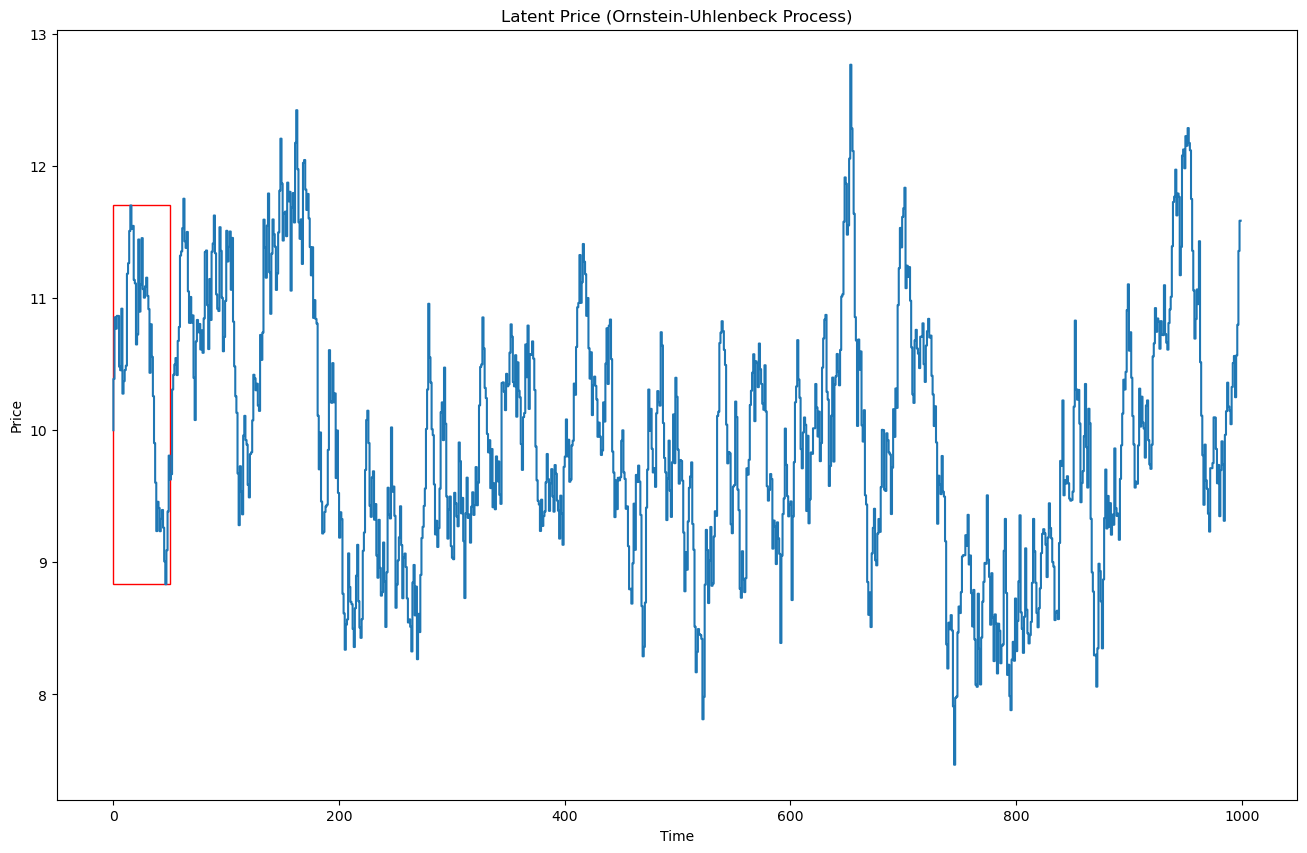

In [3]:
N_FIRST = 50

slice = pripro.time < N_FIRST
temp_latent_price = pripro.latent_price[slice]
lo, hi = temp_latent_price.min(), temp_latent_price.max()

fig, axis = plt.subplots()

pripro.plot_latent_price(axis)
axis.add_patch(Rectangle((0, lo), N_FIRST, hi-lo, edgecolor='r', fill=False))

plt.show()

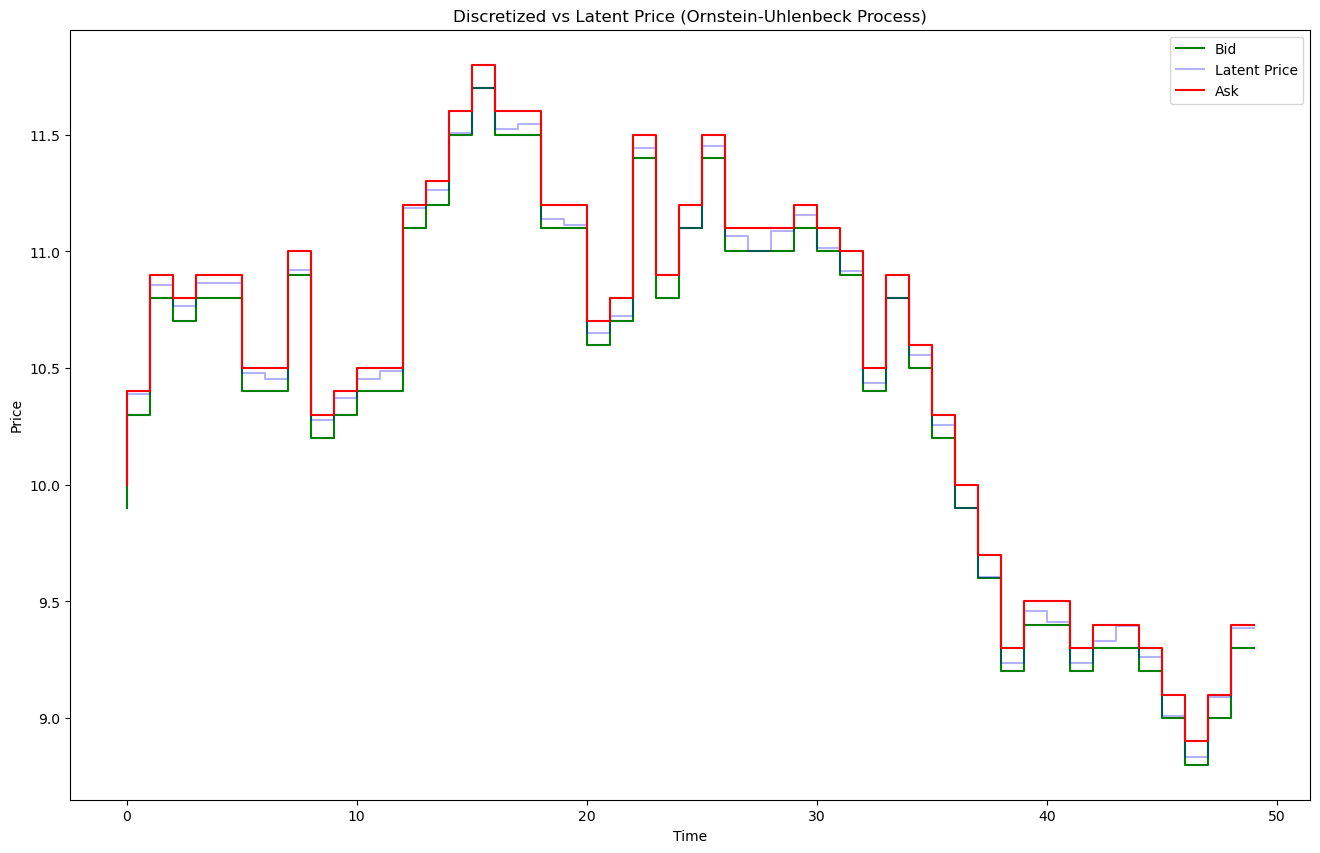

In [4]:
fig, axis = plt.subplots()

pripro.plot_bid_ask(axis, slice)

plt.show()

# Intuition

Given the difference equation, we can estimate where 

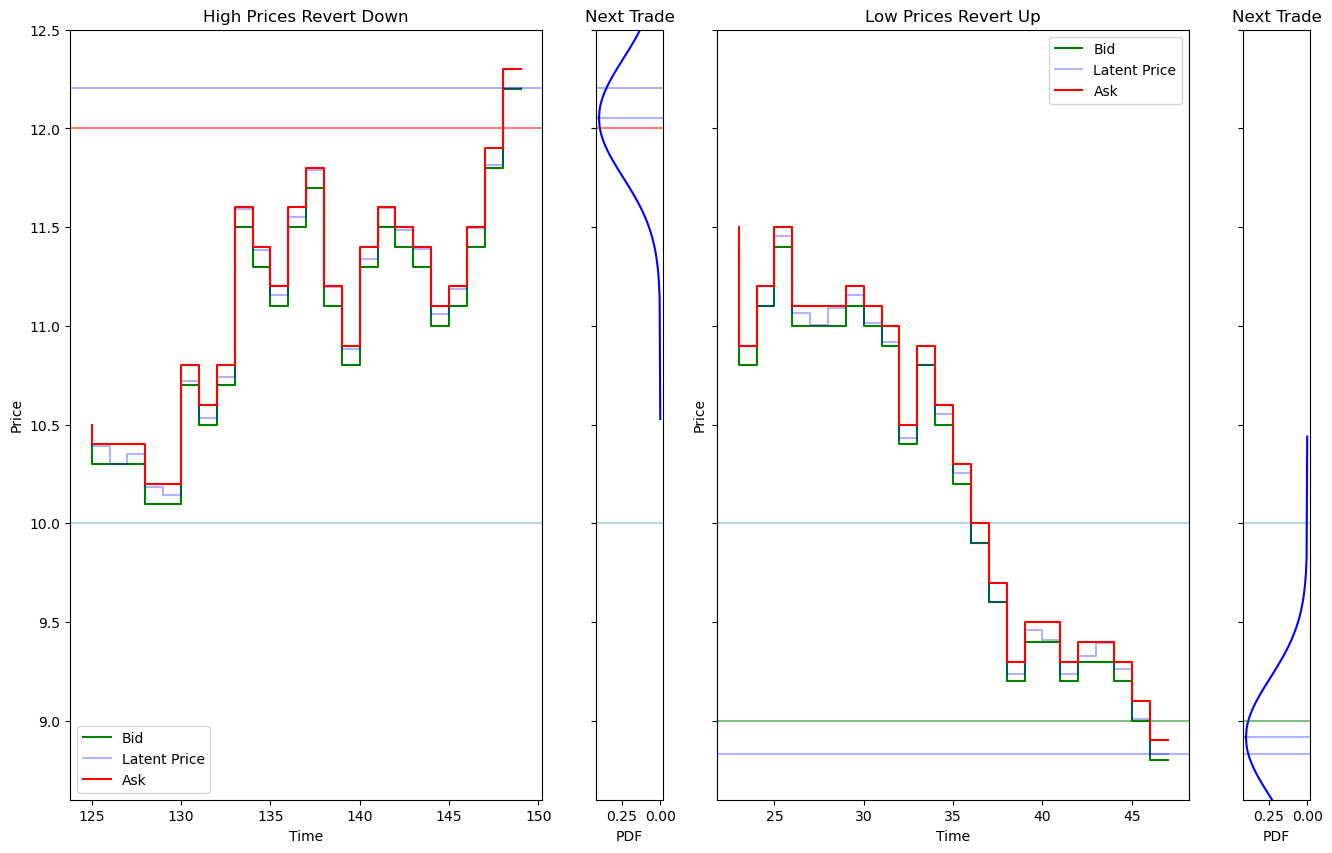

In [5]:
slice = 25

hi_bound = X0 + 20*TICKSIZE
lo_bound = X0 - 10*TICKSIZE

hi_loc = np.argmax(pripro.latent_price>hi_bound)
lo_loc = np.argmax(pripro.latent_price<lo_bound)
hi_latent = pripro.latent_price[hi_loc]
lo_latent = pripro.latent_price[lo_loc]

fig, axs = plt.subplots(1, 4, gridspec_kw={"width_ratios": [7,1,7,1]}, sharey=True)

for axx in axs:
    axx.axhline(X0, alpha=0.3)

pripro.plot_bid_ask(axs[0], (hi_loc-slice < pripro.time) & (pripro.time <= hi_loc))
axs[0].axhline(hi_bound, color='r', alpha=0.5)
axs[0].axhline(hi_latent, color='b', alpha=0.3)
axs[0].set(title="High Prices Revert Down")

pripro.dynamics.plot_next_pdf(axs[1], hi_latent)
axs[1].axhline(hi_bound, color='r', alpha=0.5)
axs[1].axhline(hi_latent, color='b', alpha=0.3)
axs[1].set(title="Next Trade", xlabel="PDF")

pripro.plot_bid_ask(axs[2], (lo_loc-slice < pripro.time) & (pripro.time <= lo_loc))
axs[2].axhline(lo_bound, color='g', alpha=0.5)
axs[2].axhline(lo_latent, color='b', alpha=0.3)
axs[2].set(title="Low Prices Revert Up")

pripro.dynamics.plot_next_pdf(axs[3], lo_latent)
axs[3].axhline(lo_bound, color='g', alpha=0.5)
axs[3].axhline(lo_latent, color='b', alpha=0.3)
axs[3].set(title="Next Trade", xlabel="PDF")

axs[0].set_ylabel("Price")
axs[3].set_ylim([pripro.bid_price[lo_loc]-2*TICKSIZE, pripro.ask_price[hi_loc]+2*TICKSIZE])
plt.show()

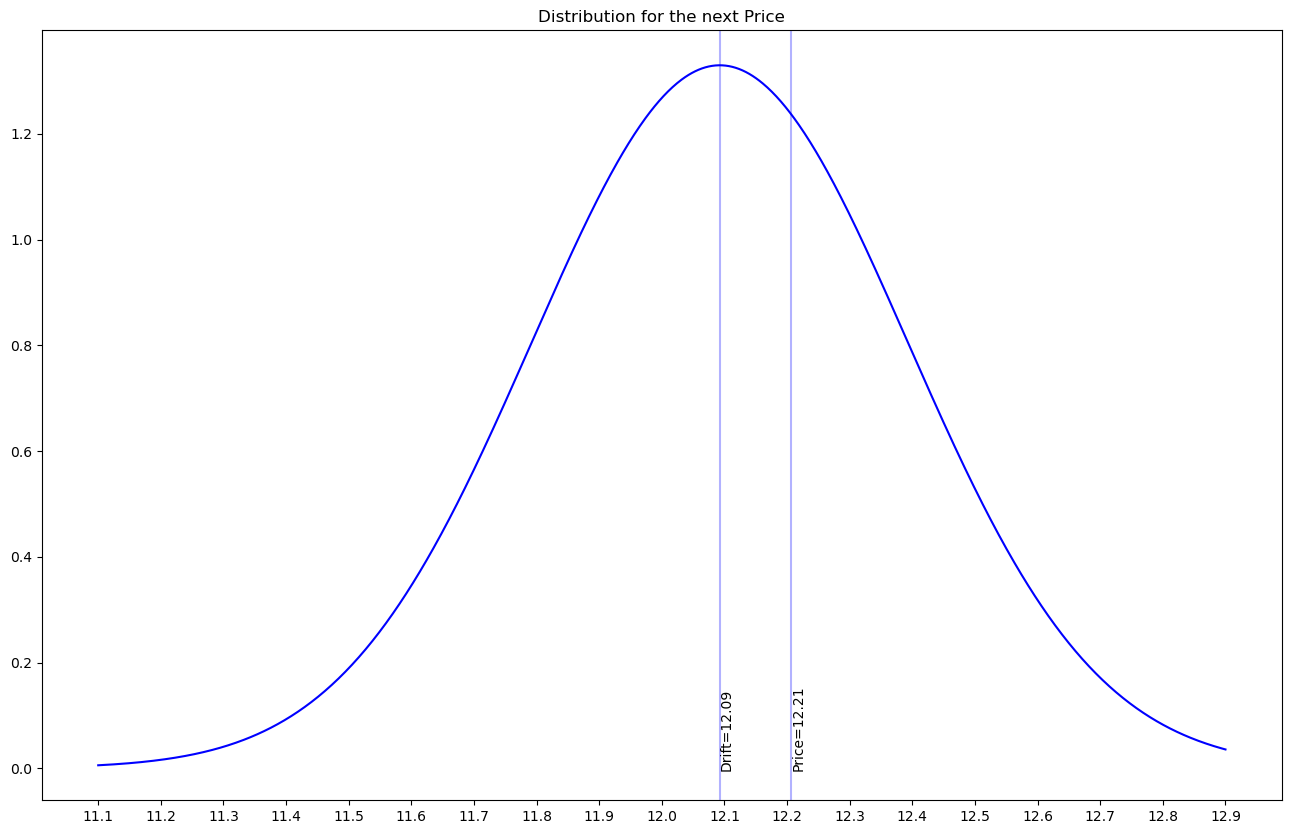

In [6]:
def round_to(x: float, rounder: float) -> float:
    return (x // rounder) * rounder

hi_bid = round_to(hi_latent, TICKSIZE)
hi_mid = hi_bid + TICKSIZE / 2
hi_ask = hi_bid + TICKSIZE

hi_drift = pripro.dynamics.theta * (pripro.dynamics.mu - hi_mid) * pripro.dynamics.deltat
hi_mean = hi_mid + hi_drift
std = pripro.dynamics.sigma * pripro.dynamics.deltat**0.5

prices = np.linspace(round_to(hi_mean - std * 3, TICKSIZE), round_to(hi_mean + std * 3, TICKSIZE), 1000)
pdf = stats.norm.pdf(prices, hi_mean, std)

fig, axs = plt.subplots()
axs.plot(prices, pdf, color='b')
axs.axvline(hi_mean, color='b', alpha=0.3)
axs.axvline(hi_latent, color='b', alpha=0.3)

axs.text(hi_latent, 0, f"Price={hi_latent:.2f}", rotation=90)
axs.text(hi_mean, 0, f"Drift={hi_mean:.2f}", rotation=90)

xti = np.round(np.arange(prices.min(), prices.max()+TICKSIZE, TICKSIZE), 1)

axs.set(title="Distribution for the next Price", xticks=xti, xticklabels=xti)

plt.show()

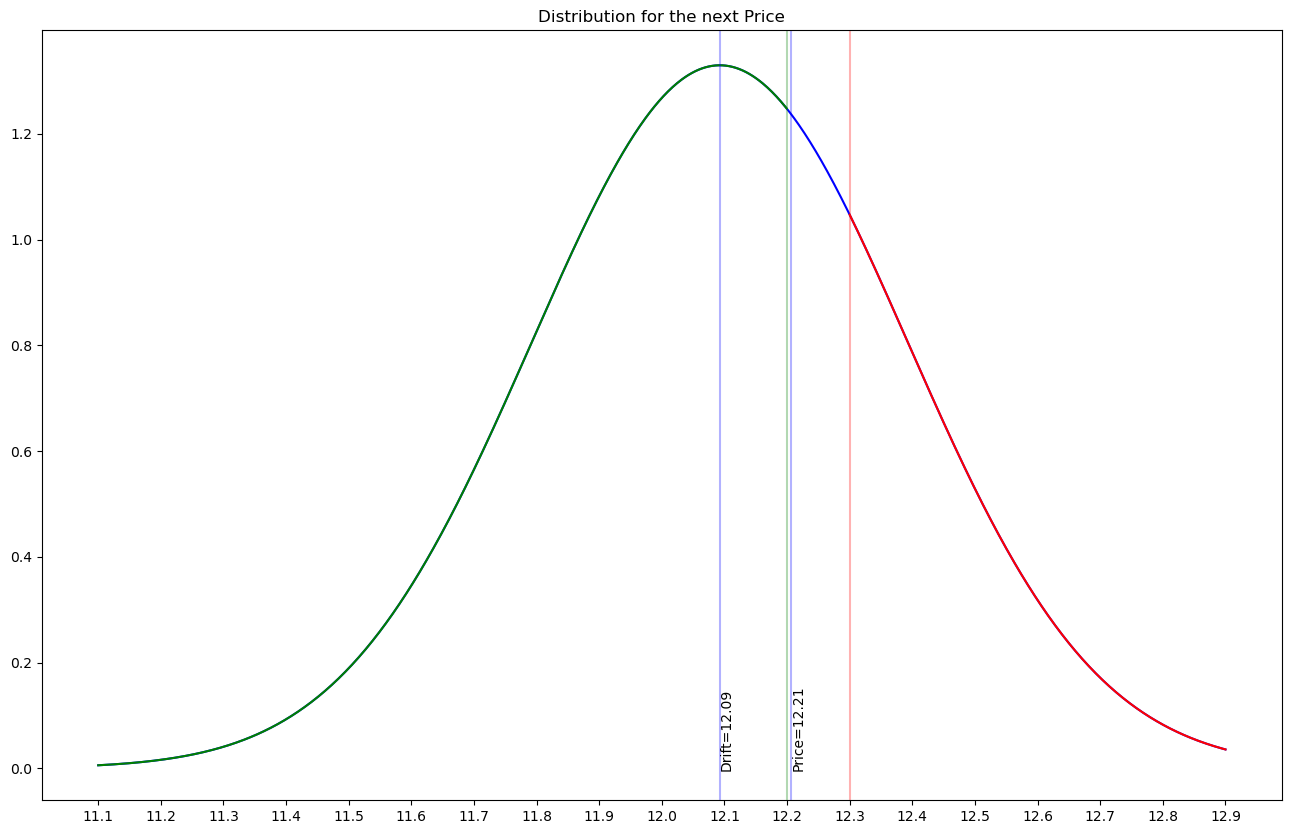

In [7]:
mask_do = prices <= hi_bid
mask_up = hi_ask <= prices

fig, axs = plt.subplots()

axs.plot(prices, pdf, color='b')
axs.plot(prices[mask_do], pdf[mask_do], color='g')
axs.plot(prices[mask_up], pdf[mask_up], color='r')
axs.axvline(hi_mean, color='b', alpha=0.3)
axs.axvline(hi_latent, color='b', alpha=0.3)
axs.axvline(hi_bid, color='g', alpha=0.3)
axs.axvline(hi_ask, color='r', alpha=0.3)

axs.text(hi_latent, 0, f"Price={hi_latent:.2f}", rotation=90)
axs.text(hi_mean, 0, f"Drift={hi_mean:.2f}", rotation=90)

axs.set(title="Distribution for the next Price", xticks=xti, xticklabels=xti)

plt.show()

In [33]:
from abc import ABC, abstractclassmethod


class TradingStrategy(ABC):

    exposure: float

    @abstractclassmethod
    def backtest(self):
        pass

    @abstractclassmethod
    def size_position(self):
        pass


class MeanRevertingStrategy(TradingStrategy):

    def __init__(self, pripro: PriceProcess, exposure: int = int(1e5)):
        self.pripro = pripro
        self.exposure = exposure

        self.generate_sizing_factors()

    def backtest(self):
        self.positions = np.zeros(self.pripro.time.shape[0])

        for time in self.pripro.time:
            mid = pripro.mid_price[time]

    def size_position(self, mid: float):
        pass

    def generate_sizing_factors(self):
        self.mids = np.arange(X0 - 3 * self.pripro.dynamics.sigma,
                              X0 + 3 * self.pripro.dynamics.sigma,
                              self.pripro.ticksize) + self.pripro.ticksize / 2

        self.edo = np.zeros(self.mids.shape)
        self.eup = np.zeros(self.mids.shape)
        self.pdo = np.zeros(self.mids.shape)
        self.pup = np.zeros(self.mids.shape)

        for i in range(self.mids.shape[0]):
            mid = self.mids[i]
            bid = round_to(mid, TICKSIZE)
            ask = bid + TICKSIZE

            drift = self.pripro.dynamics.theta * (self.pripro.dynamics.mu - mid) * self.pripro.dynamics.deltat

            self.pdo[i] = stats.norm.cdf(bid, mid+drift, std)
            self.pup[i] = stats.norm.sf(ask,  mid+drift, std)

            self.edo[i] = mid - stats.norm.expect(loc=mid+drift, scale=std, ub=bid) / self.pdo[i]
            self.eup[i] = stats.norm.expect(loc=mid+drift, scale=std, lb=ask) / self.pup[i] - mid

        self.tot = self.pdo + self.pup

    def plot_sizing_params(self, axis: plt.Axes):
        axis[0].plot(self.mids, self.edo, color='r', label="Short given Down")
        axis[0].plot(self.mids, self.eup, color='g', label="Long given Up")
        axis[0].legend()
        axis[0].set(title="Dollar Return given Outcome")

        axis[1].plot(self.mids, self.pdo, color='r', label="Down")
        axis[1].plot(self.mids, self.pup, color='g', label="Up")
        axis[1].plot(self.mids, 1-self.tot, color='b', label="Flat")
        axis[1].axhline(1)
        axis[1].legend()
        axis[1].set(title="Probability of Next Price Change")

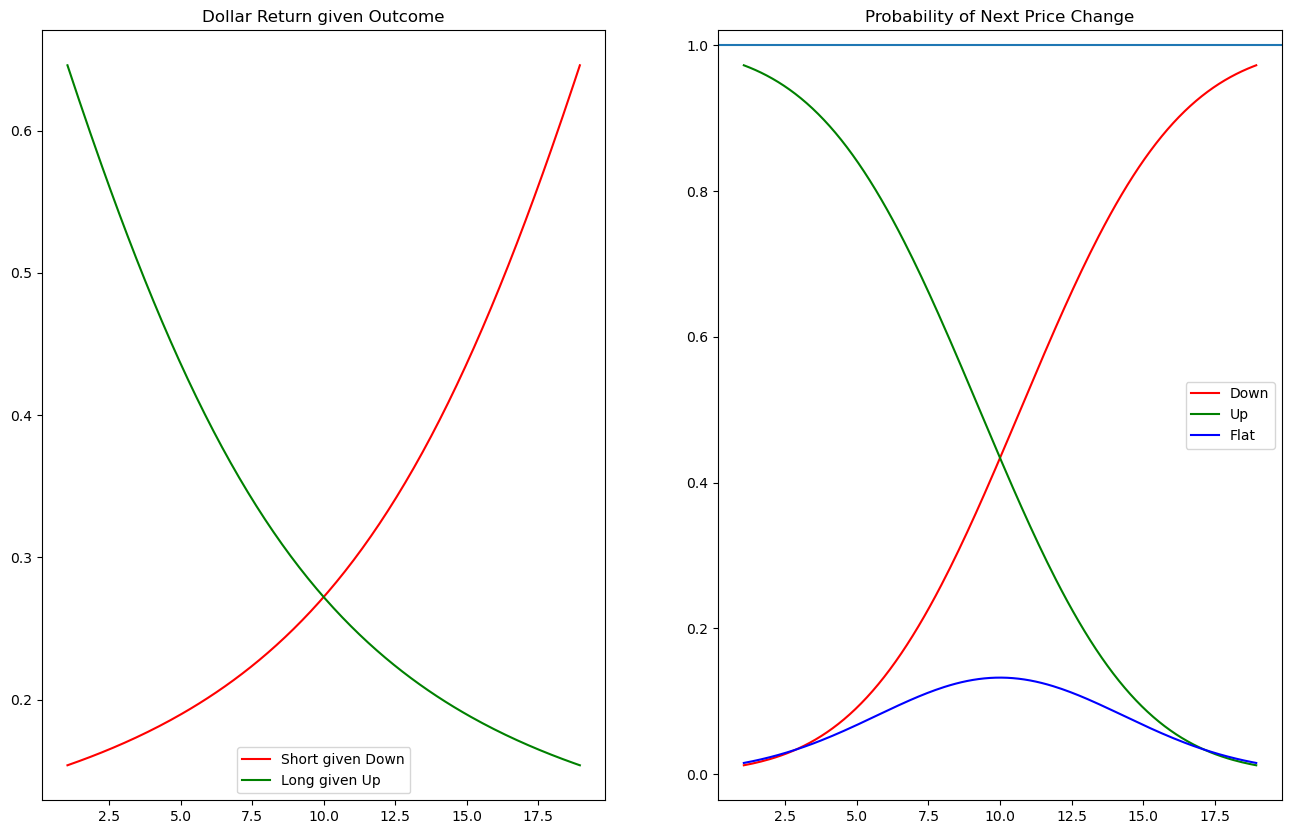

In [34]:
strat = MeanRevertingStrategy(pripro, int(1e4))

fig, axs = plt.subplots(1,2)

strat.plot_sizing_params(axs)

plt.show()

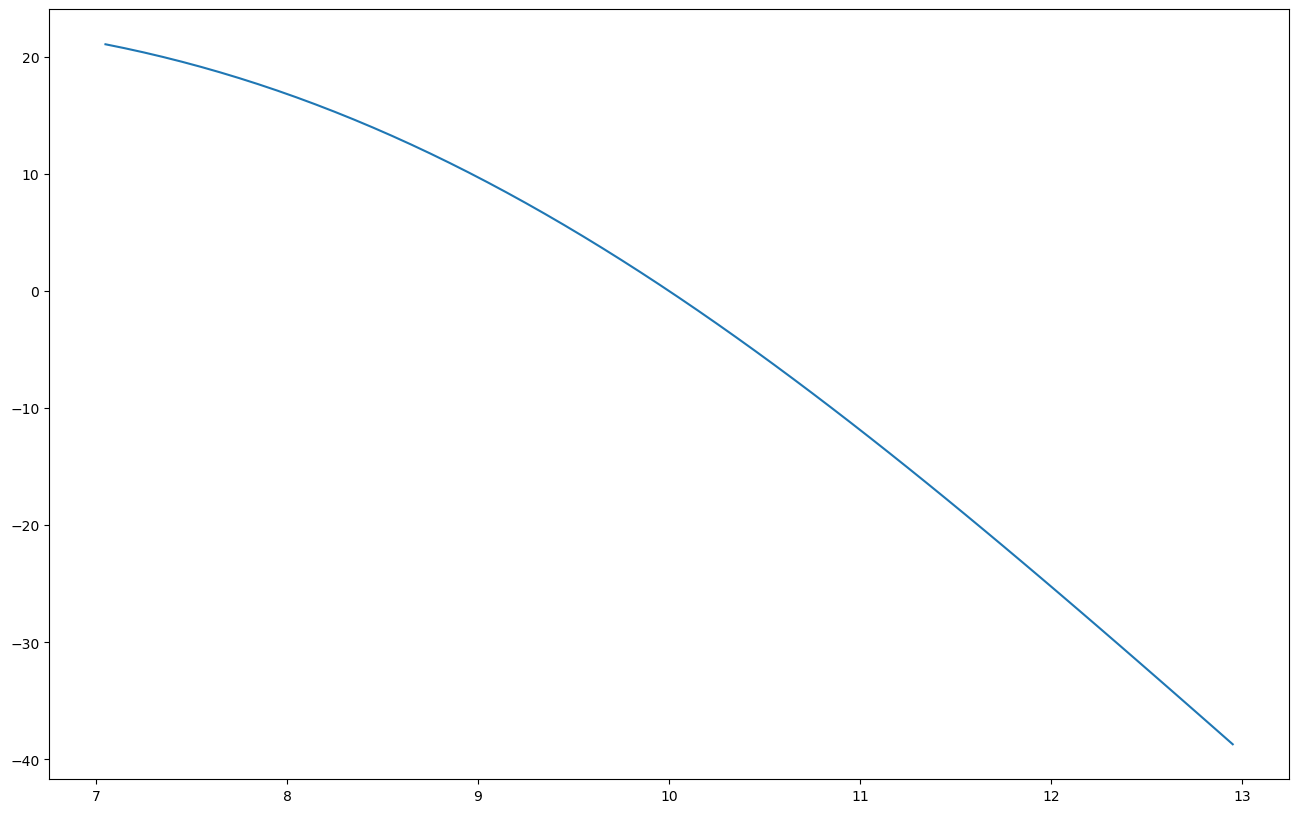

In [52]:
def kelly_criterion(p: float, q: float, a: float, b: float) -> float:
    return p/a - q/b

index = np.argmax(np.isclose(strat.mids, 10.05))

p = strat.pup / strat.tot
q = strat.pdo / strat.tot

b = strat.eup / strat.mids
a = strat.edo / strat.mids

mask_near = np.abs(strat.mids-10) < 3

plt.plot(strat.mids[mask_near], kelly_criterion(p, q, a, b)[mask_near])

In [ ]:
print(p[:5], q[:5], a[:5], b[:5], sep='\n')
print("")
print(p[-5:], q[-5:], a[-5:], b[-5:], sep='\n')

[0.98774638 0.98697297 0.98615711 0.98529691 0.98439041]
[0.01225362 0.01302703 0.01384289 0.01470309 0.01560959]
[0.14644767 0.13432749 0.12415319 0.11549246 0.10803223]
[0.615159   0.55637677 0.50702624 0.46501201 0.42881669]

[0.01560959 0.01470309 0.01384289 0.01302703 0.01225362]
[0.98439041 0.98529691 0.98615711 0.98697297 0.98774638]
[0.03351936 0.03366039 0.03380175 0.03394341 0.03408533]
[0.00844457 0.00836004 0.00827688 0.00819505 0.00811451]
